# Using convnets with small datasets

-  Chapter 5, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff)


In [16]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [17]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
import os
import datetime

1.15.2


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in 
practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on 
classifying images as "dogs" or "cats", in a dataset containing 3000 pictures of cats and dogs (1500 cats, 1500 dogs). We will use 2000 
pictures for training and 1000 for validation.

In this section, we will review one basic strategy to tackle this problem: **training a new model from scratch on what little data we have**. 

We will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be 
achieved. This will get us to a classification accuracy of ~75%. At that point, our main issue will be overfitting. Then we will introduce 
*data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve 
our network to reach an accuracy of ~82%.

In the next section, we will review two more essential techniques for applying deep learning to small datasets: *doing feature extraction 
with a pre-trained network* (this will get us to an accuracy of 90% to 93%), and *fine-tuning a pre-trained network* (this will get us to 
our final accuracy of 95%). Together, these three strategies -- training a small model from scratch, doing feature extracting using a 
pre-trained model, and fine-tuning a pre-trained model -- will constitute your future toolbox for tackling the problem of doing computer 
vision with small datasets.

## The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental 
characteristic of deep learning is that it is **able to find interesting features in the training data on its own**, without any need for manual 
feature engineering, and this can only be achieved when **lots of training examples are available**. This is especially true for problems where 
the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for 
starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can 
potentially suffice if the model is small and well-regularized and if the task is simple. 
Because **convnets learn local, translation-invariant features**, they are very 
**data-efficient** on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results 
despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature **highly repurposable**: you can take, say, an image classification or speech-to-text model 
trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of 
computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used 
to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.

## Downloading the data

The cats vs. dogs dataset was made available by Kaggle.com as part of a computer vision 
competition in late 2013, back when convnets weren't quite mainstream. 

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 
95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our 
models on less than 10% of the data that was available to the competitors.

This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). We will use a subset of the original dataset: a training set with 1000 samples of each class, a validation set with 500 samples of each class.


The **reduced dataset** has the following directory structure: 
```
cats_and_dogs_filtered
|__ train
    |______ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ validation
    |______ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
```

In [19]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 3s 0us/step


In [20]:
PATH

'/root/.keras/datasets/cats_and_dogs_filtered'

In [21]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures


As a sanity check, let's count how many pictures we have in each training split (train / validation / test).

In [22]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [23]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000



So we have indeed 2000 training images and 1000 validation images. In each split, there is the same number of 
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate 
measure of success.

/root/.keras/datasets/cats_and_dogs_filtered/train/dogs


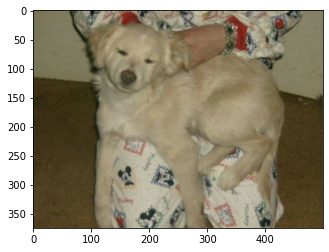

In [24]:
# !pip install Pillow # uncomment if needed
from PIL import Image
from matplotlib.pyplot import imshow

print(train_dogs_dir)
example_img = os.path.join(train_dogs_dir,os.listdir(train_dogs_dir)[40])
image = Image.open(example_img,'r')
imshow(image)


## Building our network

We've already built a small convnet for MNIST in the previous example, so you should be familiar with them. We will reuse the same 
general structure: our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one 
more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the 
feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a 
somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is 
decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a 
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [25]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

For our compilation step, we'll go with the `adam` optimizer as usual. Since we ended our network with a single sigmoid unit, we will 
use binary crossentropy as our loss.

In [27]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RGB grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (*int8 bit* implies values between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image 
processing helper tools, located at `tensorflow.keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we 
will use here.

In [28]:
BATCH_SIZE = 50
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(50, 150, 150, 3)`) and binary 
labels (shape `(50,)`). 50 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.


In [30]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (50, 150, 150, 3)
labels batch shape: (50,)


Let's fit our model to the data using the generator. 
- with some older versions of tensorflow 1.x you must use the `fit_generator` method, the equivalent of `fit` for data generators 
- with tensorflow 2.x `fit` supports generators and `fit_generator` is deprecated.

Because the data is being generated endlessly, the generator needs to know how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, 
batches are 50-sample large, so it will take 40 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is 
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, 
which tells the process how many batches to draw from the validation generator for evaluation.

In [31]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=total_train // BATCH_SIZE,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=total_val // BATCH_SIZE)

Epoch 1/30
40/40 [==============================] - 11s 269ms/step - loss: 0.7017 - acc: 0.4930 - val_loss: 0.6901 - val_acc: 0.6500
Epoch 2/30
40/40 [==============================] - 9s 216ms/step - loss: 0.6943 - acc: 0.5360 - val_loss: 0.6914 - val_acc: 0.5040
Epoch 3/30
40/40 [==============================] - 9s 217ms/step - loss: 0.6932 - acc: 0.5110 - val_loss: 0.6922 - val_acc: 0.5000
Epoch 4/30
40/40 [==============================] - 9s 214ms/step - loss: 0.6921 - acc: 0.4885 - val_loss: 0.6870 - val_acc: 0.5120
Epoch 5/30
40/40 [==============================] - 9s 216ms/step - loss: 0.6813 - acc: 0.5620 - val_loss: 0.6707 - val_acc: 0.6130
Epoch 6/30
40/40 [==============================] - 9s 214ms/step - loss: 0.6716 - acc: 0.5730 - val_loss: 0.6805 - val_acc: 0.6010
Epoch 7/30
40/40 [==============================] - 9s 213ms/step - loss: 0.6567 - acc: 0.6315 - val_loss: 0.6338 - val_acc: 0.6500
Epoch 8/30
40/40 [==============================] - 9s 216ms/step - loss: 0

It is good practice to always save your models after training:

In [32]:
dir_name ="/content/drive/My Drive/CIDL_Example/7_using_CNN_with_small_datasets"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name,'cats_and_dogs_small_2.h5'))

Let's plot the loss and accuracy of the model over the training and validation data during training:

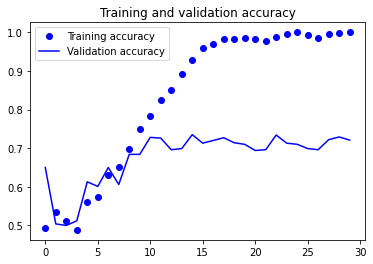

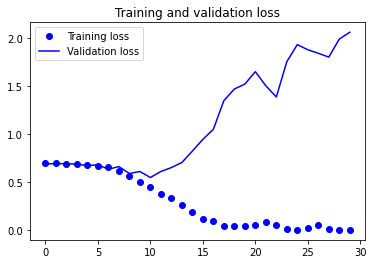

In [33]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 75%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a 
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to 
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data 
augmentation*.

## Early Stopping

Another frequently used form of regularization is represented by **early stopping**: at the end of each epoch we monitor the classification accuracy (or loss) on validation data; when the monitored quantity stops improving, we stop training.

This technique allows to fight overfitting by automatically adjusting the number of training epochs. 

Early-stopping can be easily implemented in tf.keras thanks to the dedicated **callback**, i.e. a utility called at certain points during model training.
From  [tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping):

```python
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
model.fit(data, labels, epochs=100, callbacks=[callback],
    validation_data=(val_data, val_labels)
```

## Using data augmentation

Overfitting is caused by having too few samples to learn from, preventing us to train a model able to generalize to new data. 

Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data 
augmentation takes the approach of generating more training data from existing training samples, by **"augmenting" the samples via a number 
of random transformations** that yield believable-looking images. The goal is that at training time, our model would never see the exact same 
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` 
instance. Let's get started with an example:

In [34]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2, # https://en.wikipedia.org/wiki/Shear_mapping
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

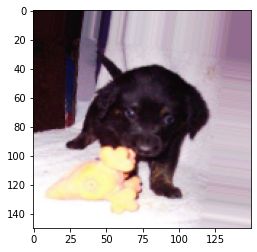

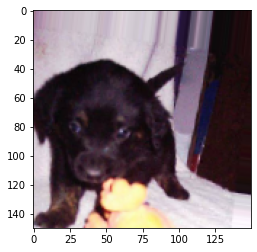

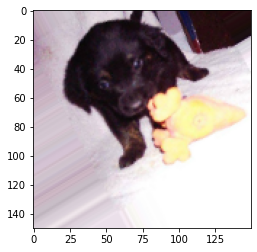

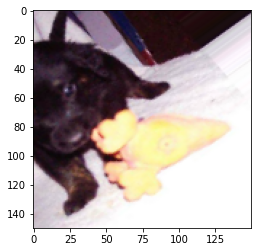

In [35]:
train_dogs_dir = os.path.join(train_dir,'dogs')
# This is module with image preprocessing utilities
from tensorflow.keras.preprocessing import image
fnames = [os.path.join(train_dogs_dir, fname) for fname in os.listdir(train_dogs_dir)]
# We pick one image to "augment"
img_path = fnames[3]
# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))
# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)
# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)
# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this **data augmentation** configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- **we cannot produce new information**, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a **Dropout layer** to our model, right before the densely-connected classifier:

In [38]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Let's train our network using data augmentation and dropout:

In [39]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=total_train // BATCH_SIZE,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=total_val // BATCH_SIZE,)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
40/40 [==============================] - 20s 500ms/step - loss: 0.6931 - acc: 0.5190 - val_loss: 0.6819 - val_acc: 0.6020
Epoch 2/100
40/40 [==============================] - 17s 430ms/step - loss: 0.6933 - acc: 0.5140 - val_loss: 0.6895 - val_acc: 0.5130
Epoch 3/100
40/40 [==============================] - 17s 427ms/step - loss: 0.6838 - acc: 0.5615 - val_loss: 0.6537 - val_acc: 0.6030
Epoch 4/100
40/40 [==============================] - 17s 429ms/step - loss: 0.6807 - acc: 0.5585 - val_loss: 0.6517 - val_acc: 0.5640
Epoch 5/100
40/40 [==============================] - 17s 437ms/step - loss: 0.6378 - acc: 0.6300 - val_loss: 0.6149 - val_acc: 0.6600
Epoch 6/100
40/40 [==============================] - 17s 428ms/step - loss: 0.6441 - acc: 0.6545 - val_loss: 0.6762 - val_acc: 0.5890
Epoch 7/100
40/40 [==============================] - 17s 429ms/step - loss: 0.6490 - acc: 0.6350 - val_loss: 0.6

Let's save our model.

In [40]:
model.save(os.path.join(dir_name,'cats_and_dogs_small_3.h5'))

Let's plot our results again:

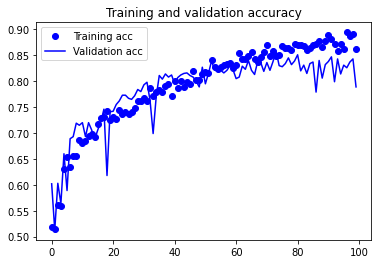

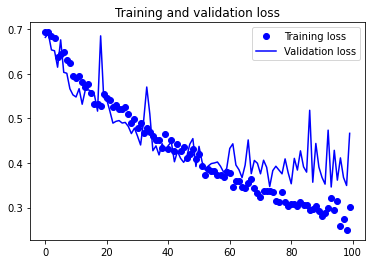

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we have significantly reduced overfitting: the training curves are rather closely tracking the validation 
curves. We are now able to reach an accuracy of ~84%, almost 10% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution 
layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove 
very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a 
next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next notebook.